# AI Warriors FINAL SOLUTION NOTEBOOK
## Task 4 - Image and Video Analysis

## Imports

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout,Conv2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
import tensorflow.keras as M

from keras import backend as K

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# Model
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import tqdm

## Utility Functions

## Training Data Exploration

In [3]:
train = pd.read_csv('/kaggle/input/task4aiijc/train_scores.csv')

In [4]:
train

,images,prompt,SCORE
0,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"a close up of a bowl of food on a table, a pic...",3
1,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"a boat on a body of water under a cloudy sky, ...",9
2,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"two men shaking hands in front of flags, a pho...",8
3,/kaggle/input/task4aiijc/task_4/task_4/train/t...,a white lighthouse sitting on top of a lush gr...,8
4,/kaggle/input/task4aiijc/task_4/task_4/train/t...,a dirt road surrounded by trees on a cloudy da...,8
...,...,...,...
99905,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"a wooden bookcase filled with lots of books, a...",6
99906,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"a glass pitcher sitting on top of a table, an ...",5
99907,/kaggle/input/task4aiijc/task_4/task_4/train/t...,a black and white bird standing on top of a lu...,7
99908,/kaggle/input/task4aiijc/task_4/task_4/train/t...,"a crowd of people watching a baseball game, a ...",5


(array([  215.,  3456.,  8117., 12007.,     0., 19829., 23350., 29646.,
         3235.,    55.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

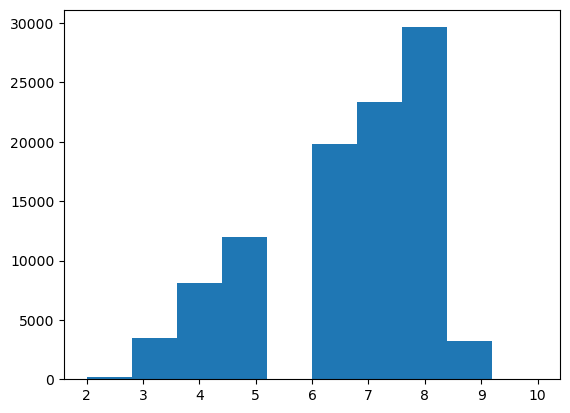

In [5]:
plt.hist(np.array(train['SCORE']))

Image dimensions
(361, 540, 3)


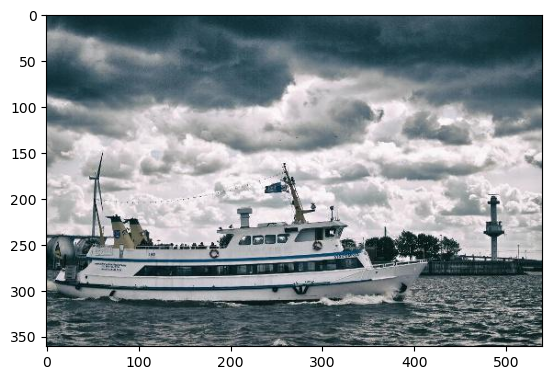

In [6]:
img = plt.imread(train['images'][1])
print("Image dimensions")
print(img.shape)
plt.imshow(img)

In [8]:
train_df=train
df=train
df["SCORE"] = df["SCORE"].astype(np.float32)

## Data Split

In [13]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Model

In [14]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

### Data Loading

In [16]:
class ImageRatingDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row["images"]
        rating = row["SCORE"]
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(text=["picture aesthetic score 1 ,picture aesthetic score  2,picture aesthetic score  3,picture aesthetic score  4,picture aesthetic score  5,picture aesthetic score  6,picture aesthetic score  7,picture aesthetic score  8,picture aesthetic score  9,picture aesthetic score  10"], images=[image], return_tensors="pt", padding=True)
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return inputs, rating

train_dataset = ImageRatingDataset(train_df, processor)
test_dataset = ImageRatingDataset(test_df, processor)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128)

### Parameters / Hyper-parameters Settings

#### Loss Function

In [ ]:
def emd_loss(predicted_score, actual_score):
    # Compute the cumulative sum of the scores along the score dimension
    predicted_cumsum = torch.cumsum(predicted_score, dim=0)
    actual_cumsum = torch.cumsum(actual_score, dim=0)
    # Compute the absolute difference between the cumulative sums
    abs_diff = torch.abs(predicted_cumsum - actual_cumsum)
    # Compute the emd loss by summing the absolute differences
    emd_loss = torch.sum(abs_diff, dim=0)
    return emd_loss

# Define the mixture of L1, L2, L3, and MSE loss functions
def mixed_loss(predicted_score, actual_score):
    # Compute the L1 loss
    l1_loss = F.l1_loss(predicted_score, actual_score, reduction='none')
    # Compute the L2 loss
    l2_loss = F.mse_loss(predicted_score, actual_score, reduction='none')
    # Compute the L3 loss
    l3_loss = torch.pow(torch.abs(predicted_score - actual_score), 3)
    # Compute the mixed loss by averaging the Three losses
    mixed_loss = (l1_loss + l2_loss + l3_loss ) / 3
    return mixed_loss

# Define the final loss function that combines emd and mixed losses
def final_loss( predicted_score, actual_score):
    # Compute the emd loss
    emd = emd_loss(predicted_score, actual_score)
    # Compute the mixed loss
    mixed = mixed_loss(predicted_score, actual_score)
    # Compute the final loss by adding the emd and mixed losses
    final_loss =  emd+mixed ######              MAKE SURE
    final_loss = torch.mean(final_loss)
    return final_loss

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-7, weight_decay=0.08)
p=0

## Training

In [ ]:
epochs = 15

for epoch in range(epochs):
    model.train()
    torch.cuda.synchronize()
    train_loss = 0.0

    for batch, ratings in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits_per_text = outputs.logits_per_text # shape: (batch_size, num_labels)
        ratings = ratings.to(device) # shape: (batch_size,)
        loss = criterion(logits_per_text.squeeze(), ratings.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    test_loss = 0.0
    preds = []
    targets = []
    for batch, ratings in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits_per_text = outputs.logits_per_text # shape: (batch_size, num_labels)
            ratings = ratings.to(device) # shape: (batch_size,)
            loss = criterion(logits_per_text.squeeze(), ratings.float())
            test_loss += loss.item()
            preds.append(logits_per_text.squeeze().cpu().numpy())
            targets.append(ratings.cpu().numpy())
    test_loss /= len(test_dataloader)
    preas=[]
    targe=[]
    for i in range(len(preds)):
        for ii in range(len(preds[i][0])):
            preas.append(preds[i][0][ii])
            targe.append(targets[i][ii])
    preas = np.array(preas)
    targe = np.array(targe)

    r2 = r2_score(targe, preas)
    mse = mean_squared_error(targe, preas)
    mae = mean_absolute_error(targe, preas)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, epoch_{p} ")
    p+=1
    torch.save(model.state_dict(), f'L1_model_base_32_epoch_{p}_Train Loss:{train_loss:.4f},Test Loss:{test_loss:.4f},R2:{r2:.4f},MSE:{mse:.4f},MAE:{mae:.4f}.pt')


 86%|████████▌ | 539/625 [28:39<04:27,  3.11s/it]

In [51]:
waights = torch.load('/kaggle/working/L1_model_base_32_epoch_3_Train Loss:0.4826,Test Loss:0.5327,R2:0.7695,MSE:0.5152,MAE:0.5336.pt')
model.load_state_dict(waights)

<All keys matched successfully>

## Testing

In [24]:
test_loss = 0.0
preds = []
targets = []
for batch, ratings in tqdm.tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        logits_per_text = outputs.logits_per_text # shape: (batch_size, num_labels)
        ratings = ratings.to(device) # shape: (batch_size,)
        loss = criterion(logits_per_text.squeeze(), ratings.float())
        test_loss += loss.item()
        preds.append(logits_per_text.squeeze().cpu().numpy())
        targets.append(ratings.cpu().numpy())
test_loss /= len(test_dataloader)
preas=[]
targe=[]
for i in range(len(preds)):
    for ii in range(len(preds[i][0])):
        preas.append(preds[i][0][ii])
        targe.append(targets[i][ii])
preas = np.array(preas)
targe = np.array(targe)

r2 = r2_score(targe, preas)
mse = mean_squared_error(targe, preas)
mae = mean_absolute_error(targe, preas)
print(f"Test Loss: {test_loss:.4f}, R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, ")

  0%|          | 0/157 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 156/157 [06:36<00:02,  2.49s/it]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 157/157 [06:36<00:00,  2.53s/it]

Test Loss: 0.3867, R2: 0.8266, MSE: 0.3877, MAE: 0.4842, 


## Generating submission CSV file

In [ ]:
df = pd.read_csv("/kaggle/input/task4aiijc/SUBMISSION.csv")

In [ ]:
img = plt.imread(df['images'][9])
print("Image dimensions",'   ' )
print(img.shape)
plt.imshow(img)

In [ ]:
sub = ImageRatingDataset(df, processor)
sub = DataLoader(sub, batch_size=128, shuffle=False)

In [ ]:
preds = []
for batch, ratings in tqdm.tqdm(sub):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        logits_per_text = outputs.logits_per_text # shape: (batch_size, num_labels)
        ratings = ratings.to(device) # shape: (batch_size,)
        loss = criterion(logits_per_text.squeeze(), ratings.float())
        preds.append(logits_per_text.squeeze().cpu().numpy())

preas=[]
for i in range(len(preds)):
    for ii in range(len(preds[i][0])):
        preas.append(preds[i][0][ii])
#         print(i,ii)
preas = np.array(preas)


In [ ]:
model.eval()

In [ ]:
df = df.assign(SCORE=preas)

for i in range(len(df)):
    df['images'][i]=df['images'][i][49:]

df['IMAGE'] = df['images']
df = df.drop(['prompt','images'], axis=1)

In [ ]:
df.to_csv("image_score_pred.csv", index=False)